# FCC Pythia + Delphes + Heppy Analysis

-   [Overview](#Overview)
-   [Generate and Simulate Events](#Part-I:-Generate-and-simulate-Events-with-FCCSW)
-   [Analyze Events](#Part-II:-Analyze-the-output-with-Heppy)
-   [Plot events](#Part-III:-Produce-plots)
-   [Homework exercise](#Part-IV:-Homework)

## Overview

This tutorial will teach you how to:

-   **generate** signal and background samples with **Pythia8** within FCCSW
-   run a fast parametric **detector simulation** with **Delphes** within FCCSW
-   apply an **event selection** on those samples with **Heppy**
-   produce **flat ntuples** with observables of interest with Heppy
-   produce plots


But first, make sure your **setup of the FCC software** is working correctly. A quick check is that the executable `fccrun`, which allows you to run jobs in the Gaudi framework is available on the command line:


In [1]:
!which fccrun

/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoegt4ihhel4xnt62yw/scripts/fccrun


If the above command fails without printing a path like `/cvmfs/fcc.cern.ch/sw/releases/fccsw/0.10/x86_64-centos7-gcc62-opt/scripts/fccrun` check [**the documentation page on FCC software setup**](https://github.com/HEP-FCC/fcc-tutorials/blob/master/FccSoftwareGettingStarted.md).

## Part I: Generate and simulate Events with FCCSW

For this tutorial we will consider the following **physics processes**:

-   p p -> H -> 4 l
-   p p -> Z/gamma Z/gamma -> 4 l

Pythia can be configured to hadronize previously generated hard scattering in the form of Les Houches event files (`.lhe`),
or generate the hard process itself and then run the parton shower and hadronization.
**In either case, the FCCSW takes as input a Pythia8 configuration file** (`.cmd`), and does not need to know which approach was used. 

For this tutorial, we are going to run Pythia8 on previously produced LHE files (with [MG5_aMCatNLO](https://launchpad.net/mg5amcnlo)).
Additional Pythia8 configurations can be found in `FCCSW/Generation/data`.

In [2]:
%%writefile Pythia_pp_h_4l.cmd
! File: Pythia_LHEinput.cmd 
!
! This file contains commands to be read in for a Pythia8 run.
! Lines not beginning with a letter or digit are comments.
! Names are case-insensitive  -  but spellings-sensitive!
! Adjusted from Pythia example: main42.cmnd

! 1) Settings that will be used in a main program.
Main:numberOfEvents = 1            ! number of events to generate
Main:timesAllowErrors = 3          ! abort run after this many flawed events
#Random:seed = 1234                ! initialize random generator with a seed


! 2) Settings related to output in init(), next() and stat() functions.
Init:showChangedSettings = on      ! list changed settings
Init:showAllSettings = off         ! list all settings
Init:showChangedParticleData = on  ! list changed particle data
Init:showAllParticleData = off     ! list all particle data
Next:numberCount = 10              ! print message every n events
Next:numberShowLHA = 1             ! print LHA information n times
Next:numberShowInfo = 1            ! print event information n times
Next:numberShowProcess = 1         ! print process record n times
Next:numberShowEvent = 1           ! print event record n times
Stat:showPartonLevel = off         ! additional statistics on MPI

! 3b) PDF settings. Default is to use internal PDFs
! some pdf sets examples: cteq61.LHpdf cteq61.LHgrid MRST2004nlo.LHgrid
#PDF:pSet = LHAPDF5:MRST2001lo.LHgrid
! Allow extrapolation of PDF's beyond x and Q2 boundaries, at own risk.
! Default behaviour is to freeze PDF's at boundaries.
#PDF:extrapolate = on

! 4) Read-in Les Houches Event file - alternative beam and process selection.
Beams:frameType = 4                      ! read info from a LHEF
Beams:LHEF = pp_h_4l.lhe

! 5) Other settings. Can be expanded as desired.
! Note: may overwrite some of the values above, so watch out.


Writing Pythia_pp_h_4l.cmd


The detector response of the the baseline FCC-hh detector configuration is calculated with Delphes.
Other detector cards can be found in the `$DELPHES_DIR/cards` directory, such as a ATLAS, CMS or ILD detector configurations:
`delphes_card_ATLAS.tcl`, `delphes_card_CMS.tcl` and `delphes_card_ILD.tcl`. Many of the questions you might have on Delphes Fast Simulation are probably answered
[here](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook).

Both Pythia8 and Delphes are integrated in the Gaudi-based FCCSW framework as *Algorithms*. A job that runs the whole workflow consists of the following:

* `GenAlg` (Top level Generation Algorithm, with a `tool` that calls Pythia8)
* `HepMCConverter` (takes the HepMC output and translates it to the FCC event data model, understood by the Sim Algorithm)
* `DelphesSimulation`(Delphes integration, outputs reconstructed objects in the FCC event data model)
* `PodioOutput` (writes the event data to a root file on disk)

To run this job, a job options like the following is needed (**Note:** While the format of the configuration is a python file, it is not necessarily "pythonic". It can be used with GaudiPython, but we will only use it as to straightforwardly write down a job description for use with `fccrun` ) 

In [3]:
%%writefile PythiaDelphes_config.py
import os
from Gaudi.Configuration import *

# Workflow Steering
from Configurables import ApplicationMgr
ApplicationMgr().EvtSel = 'NONE'
ApplicationMgr().EvtMax = 100

## Data event model based on Podio
from Configurables import FCCDataSvc
podioEvent = FCCDataSvc("EventDataSvc")
ApplicationMgr().ExtSvc += [podioEvent]
ApplicationMgr().OutputLevel = INFO

## Pythia generator
from Configurables import PythiaInterface
pythia8gentool = PythiaInterface()
pythia8gentool.Filename = os.path.join(os.environ.get("FCCSWBASEDIR", ""),"share/FCCSW/Generation/data/Pythia_ttbar.cmd")

## Write the HepMC::GenEvent to the data service
from Configurables import GenAlg
pythia8gen = GenAlg()
pythia8gen.SignalProvider = pythia8gentool
pythia8gen.hepmc.Path = "hepmc"
ApplicationMgr().TopAlg += [pythia8gen]

### Reads an HepMC::GenEvent from the data service and writes a collection of EDM Particles
from Configurables import HepMCToEDMConverter
hepmc_converter = HepMCToEDMConverter("Converter")
hepmc_converter.hepmc.Path = "hepmc"
hepmc_converter.genparticles.Path = "genParticles"
hepmc_converter.genvertices.Path = "genVertices"
ApplicationMgr().TopAlg += [hepmc_converter]

# Define all output tools that convert the Delphes collections to FCC-EDM:

from Configurables import DelphesSaveChargedParticles

muonSaveTool = DelphesSaveChargedParticles("muons")
muonSaveTool.delphesArrayName = "MuonMomentumSmearing/muons"
muonSaveTool.particles.Path      = "muons"
muonSaveTool.mcAssociations.Path = "muonsToMC"
muonSaveTool.isolationTags.Path  = "muonITags"

eleSaveTool = DelphesSaveChargedParticles("electrons")
eleSaveTool.delphesArrayName = "ElectronFilter/electrons"
eleSaveTool.particles.Path      = "electrons"
eleSaveTool.mcAssociations.Path = "electronsToMC"
eleSaveTool.isolationTags.Path  = "electronITags"

chhadSaveTool = DelphesSaveChargedParticles("pfcharged")
chhadSaveTool.delphesArrayName = "ChargedHadronFilter/chargedHadrons"
chhadSaveTool.saveIsolation = False
chhadSaveTool.particles.Path      = "pfcharged"
chhadSaveTool.mcAssociations.Path = "pfchargedToMC"


from Configurables import DelphesSaveNeutralParticles

# Particle-Flow Neutral Hadrons output tool
neuthadSaveTool = DelphesSaveNeutralParticles("pfneutrals")
neuthadSaveTool.delphesArrayName = "HCal/eflowNeutralHadrons"
neuthadSaveTool.saveIsolation = False
neuthadSaveTool.particles.Path      = "pfneutrals"
neuthadSaveTool.mcAssociations.Path = "pfneutralsToMC"

# Particle-Flow Photons output tool
pfphotonsSaveTool = DelphesSaveNeutralParticles("pfphotons")
pfphotonsSaveTool.delphesArrayName="ECal/eflowPhotons"
pfphotonsSaveTool.saveIsolation=False
pfphotonsSaveTool.particles.Path      = "pfphotons"
pfphotonsSaveTool.mcAssociations.Path = "pfphotonsToMC"
pfphotonsSaveTool.isolationTags.Path  = "pfphotonITags"

# Photons output tool
photonsSaveTool = DelphesSaveNeutralParticles("photons")
photonsSaveTool.delphesArrayName = "PhotonEfficiency/photons"
photonsSaveTool.particles.Path      = "photons"
photonsSaveTool.mcAssociations.Path = "photonsToMC"
photonsSaveTool.isolationTags.Path  = "photonITags"


from Configurables import DelphesSaveGenJets
genJetSaveTool = DelphesSaveGenJets("genJets")
genJetSaveTool.delphesArrayName = "GenJetFinder/jets"
genJetSaveTool.genJets.Path             = "genJets"
genJetSaveTool.genJetsFlavorTagged.Path = "genJetsFlavor"


from Configurables import DelphesSaveJets
jetSaveTool = DelphesSaveJets("jets")
jetSaveTool.delphesArrayName = "JetEnergyScale/jets"
jetSaveTool.jets.Path             = "jets"
jetSaveTool.jetConstituents.Path  = "jetParts"
jetSaveTool.jetsFlavorTagged.Path = "jetsFlavor"
jetSaveTool.jetsBTagged.Path      = "bTags"
jetSaveTool.jetsCTagged.Path      = "cTags"
jetSaveTool.jetsTauTagged.Path    = "tauTags"

fatjetSaveTool = DelphesSaveJets("fatjets")
fatjetSaveTool.delphesArrayName = "FatJetFinder/jets"
fatjetSaveTool.saveSubstructure = True
fatjetSaveTool.jets.Path                        = "fatjets"
fatjetSaveTool.jetConstituents.Path             = "fatjetParts"
fatjetSaveTool.jetsOneSubJettinessTagged.Path   = "jetsOneSubJettiness"
fatjetSaveTool.jetsTwoSubJettinessTagged.Path   = "jetsTwoSubJettiness"
fatjetSaveTool.jetsThreeSubJettinessTagged.Path = "jetsThreeSubJettiness"
fatjetSaveTool.subjetsTrimmingTagged.Path       = "subjetsTrimmingTagged"
fatjetSaveTool.subjetsPruningTagged.Path        = "subjetsPruningTagged"
fatjetSaveTool.subjetsPruning.Path              = "subjetsPruning"
fatjetSaveTool.subjetsSoftDropTagged.Path       = "subjetsSoftDropTagged"
fatjetSaveTool.subjetsSoftDrop.Path             = "subjetsSoftDrop"
fatjetSaveTool.subjetsTrimming.Path             = "subjetsTrimming"

from Configurables import DelphesSaveMet
metSaveTool = DelphesSaveMet("met")
metSaveTool.delphesMETArrayName = "MissingET/momentum"
metSaveTool.delphesSHTArrayName = "ScalarHT/energy"
metSaveTool.missingEt.Path = "met"


## Delphes simulator -> define objects to be written out
from Configurables import DelphesSimulation
delphessim = DelphesSimulation()
## Define Delphes card
delphessim.DelphesCard = os.path.join(os.environ.get("FCCSWBASEDIR", ""), "share/FCCSW/Sim/SimDelphesInterface/data/FCChh_DelphesCard_Baseline_v01.tcl")
delphessim.ROOTOutputFile = ""
delphessim.ApplyGenFilter = True
delphessim.outputs = [
                       "DelphesSaveChargedParticles/muons",
                       "DelphesSaveChargedParticles/electrons",
                       "DelphesSaveNeutralParticles/photons",
                       "DelphesSaveChargedParticles/pfcharged",
                       "DelphesSaveNeutralParticles/pfphotons",
                       "DelphesSaveNeutralParticles/pfneutrals",
                       "DelphesSaveGenJets/genJets",
                       "DelphesSaveJets/jets",
                       "DelphesSaveJets/fatjets",                                        
                       "DelphesSaveMet/met",
                     ]
delphessim.hepmc.Path               = "hepmc"
delphessim.genParticles.Path        = "skimmedGenParticles"
delphessim.mcEventWeights.Path      = "mcEventWeights"
ApplicationMgr().TopAlg += [delphessim]



## FCC event-data model output -> define objects to be written out
from Configurables import PodioOutput
out = PodioOutput("out")
out.filename = "FCCDelphesOutput.root"
out.outputCommands = [
                       "keep *", 
                     ]
ApplicationMgr().TopAlg += [out]




Writing PythiaDelphes_config.py


The `fccrun` allows to change most `Properties` of the job on the command line. All possible arguments to fccrun  are listed with the command 

In [4]:
!fccrun PythiaDelphes_config.py -h

 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

usage: fccrun [-h] [--dry-run] [-v] [-n NUM_EVENTS] [-l] [--gdb]
              [--ncpus NCPUS] [--ROOTOutputFile [ROOTOUTPUTFILE]]
              [--ApplyGenFilter [APPLYGENFILTER]]
              [--outputs OUTPUTS [OUTPUTS ...]] [--DelphesCard [DELPHESCARD]]
              [--PrintEmptyCounters [PRINTEMPTYCOUNTERS]] [--input [INPUT]]
              [--Filename [FILENAME]]
              [--printPythiaStatistics [PRINTPYTHIASTATISTICS]]
              [--outputCommands OUTPUTCOMMANDS [OUTPUTCOMMANDS ...]]
              [--filename [FILENAME]]
              [--hepmcStatusList HEPMCSTATUSLIST [HEPMCSTATUSLIST ...]]
              [config_files [config_files ...]]

Run job in the FCC framework

positional arguments:
  config_files          Gaudi config (python) files describing the job

optional arguments:
  -h, --help            show this help message and exit
  --dry-run             Do not actually run the job, just parse the c

Thus The following commands will run Pythia8 and Delphes and produce the relevant signal and background samples:

In [8]:
!xrdcp root://eospublic.cern.ch//eos/experiment/fcc/hh/testsamples/pp_h_4l.lhe ./pp_h_4l.lhe
!fccrun PythiaDelphes_config.py --Filename $FCCSWBASEDIR/share/FCCSW/Generation/data/Pythia_pp_h_4l.cmd --filename pp_h_4l.root -n 100

[11.74MB/11.74MB][100%][==================================================][11.74MB/s]  
 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 9cb3e83613de on Wed Sep 25 16:32:00 2019
ApplicationMgr       INFO Application Manager Configured successfully
Error in <TTree::Bronch>: Cannot find dictionary for class: HepMC::GenEvent
GenAlg.PileUpTool    INFO Current number of pileup events:  'numPileUpEvents':0
RndmGenSvc.Engine    INFO Generator engine type:CLHEP::RanluxEngine
RndmGenSvc.Engine    INFO Current Seed:1234567 Luxury:3
RndmGenSvc           INFO Using Random engine:HepRndm::Engine<CLHEP::RanluxEngine>
GenAlg.VertexSm...   INFO Smearing of interaction point with flat distribution  in x, y and z 
GenAlg.VertexSm...   INFO  applying TOF of interaction with positive beam direction
GenAlg.VertexS


 *-------  PYTHIA Process Initialization  --------------------------*
 |                                                                  |
 | We collide p+ with p+ at a CM energy of 1.000e+05 GeV            |
 |                                                                  |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |                                                    |    max (mb) |
 |                                                    |             |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Les Houches User Process(es)                  9999 |   3.000e-09 |
 |                                                                  |
 *-------  End PYTHIA Process Initialization -----------------------*

 *-------  PYTHIA 

** INFO: initializing module  Delphes                  
** INFO: initializing module  ParticlePropagator       
** INFO: initializing module  ChargedHadronTrackingEfficiency
** INFO: initializing module  ElectronTrackingEfficiency
** INFO: initializing module  MuonTrackingEfficiency   
** INFO: initializing module  ChargedHadronMomentumSmearing
** INFO: initializing module  ElectronMomentumSmearing 
** INFO: initializing module  MuonMomentumSmearing     
** INFO: initializing module  TrackMerger              
** INFO: initializing module  ECal                     
** INFO: initializing module  HCal                     
** INFO: initializing module  Calorimeter              
** INFO: initializing module  EFlowMerger              
** INFO: initializing module  EFlowFilter              
** INFO: initializing module  PhotonEfficiency         
** INFO: initializing module  PhotonIsolation          
** INFO: initializing module  ElectronFilter           
** INFO: initializing module  Electro

  1540         21  (g)                -62   874   874  1749     0   754   808 -1.157e+00 -1.151e+00 -3.328e+01  3.332e+01  0.000e+00
  1541         21  (g)                -62  1270  1270  1752     0   766   874 -2.000e+00 -3.156e+00 -4.242e+01  4.259e+01  0.000e+00
  1542         21  (g)                -62   997   997  1749     0   540   754 -3.669e-01 -4.238e-01 -1.100e+01  1.101e+01  0.000e+00
  1543         21  (g)                -62   996   996  1752     0   778   766 -7.566e-01 -1.927e+00 -2.142e+01  2.152e+01  0.000e+00
  1544         21  (g)                -62  1096  1096  1738     0   811   662  1.357e-02  7.967e-02  5.048e-02  9.529e-02  0.000e+00
  1545         21  (g)                -62  1097  1097  1750     0   796   783 -4.885e-01 -2.107e-01 -8.799e+00  8.816e+00  0.000e+00
  1546         21  (g)                -62  1200  1200  1753     0   538   795  1.988e-01 -1.955e-02  1.168e+00  1.185e+00  0.000e+00
  1547         21  (g)                -62  1181  1181  1780     0   8

  3843         22  gamma               91  3276     0     0     0     0     0 -3.521e-02  4.130e-02  1.287e+00  1.288e+00  0.000e+00
  3844        211  pi+                 91  3285     0     0     0     0     0 -8.381e-01  1.489e+00  4.019e+00  4.369e+00  1.396e-01
  3845       -211  pi-                 91  3285     0     0     0     0     0 -4.822e-01  5.974e-01  2.949e+00  3.051e+00  1.396e-01
  3846         22  gamma               91  3286     0     0     0     0     0 -9.426e-02  1.256e-01  9.334e-01  9.465e-01  0.000e+00
  3847         11  e-                  91  3286     0     0     0     0     0 -1.068e-01  1.507e-02  4.318e-01  4.451e-01  5.110e-04
  3848        -11  e+                  91  3286     0     0     0     0     0 -5.075e-02  7.704e-03  2.110e-01  2.171e-01  5.110e-04
  3849         22  gamma               91  3291     0     0     0     0     0  2.312e-01 -1.770e-01  9.593e-01  1.003e+00  0.000e+00
  3850         22  gamma               91  3291     0     0     0    

 PYTHIA Warning in Pythia::check: not quite matched particle energy/momentum/mass  
 PYTHIA Warning in Pythia::check: energy-momentum not quite conserved  

 Pythia::next(): 10 events have been generated 

 Pythia::next(): 20 events have been generated 

 Pythia::next(): 30 events have been generated 

 Pythia::next(): 40 events have been generated 

 Pythia::next(): 50 events have been generated 

 Pythia::next(): 60 events have been generated 

 Pythia::next(): 70 events have been generated 
 PYTHIA Warning in SimpleSpaceShower::pT2nextQCD: weight above unity  
 PYTHIA Warning in SimpleSpaceShower::pT2nextQCD: small daughter PDF  

 Pythia::next(): 80 events have been generated 

 Pythia::next(): 90 events have been generated 
ApplicationMgr       INFO Application Manager Stopped successfully
DelphesSimulation    INFO Exiting Delphes...
out                  INFO Data written to:  'filename':pp_h_4l.root
EventLoopMgr         INFO Histograms converted successfully according to request.

In [9]:
!xrdcp root://eospublic.cern.ch//eos/experiment/fcc/hh/testsamples/pp_zgzg_4l.lhe ./pp_zgzg_4l.lhe
!fccrun PythiaDelphes_config.py --Filename  $FCCSWBASEDIR/share/FCCSW/Generation/data/Pythia_pp_zgzg_4l.cmd --filename pp_zgzg_4l.root -n 100

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists

 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 9cb3e83613de on Wed Sep 25 16:33:37 2019
ApplicationMgr       INFO Application Manager Configured successfully
Error in <TTree::Bronch>: Cannot find dictionary for class: HepMC::GenEvent
GenAlg.PileUpTool    INFO Current number of pileup events:  'numPileUpEvents':0
RndmGenSvc.Engine    INFO Generator engine type:CLHEP::RanluxEngine
RndmGenSvc.Engine    INFO Current Seed:1234567 Luxury:3
RndmGenSvc           INFO Using Random engine:HepRndm::Engine<CLHEP::RanluxEngine>
GenAlg.VertexSm...   INFO Smearing of interaction point with flat distribution  in x, y and z 
GenAlg.VertexSm...   INFO  applying TOF of inter


 *-------  PYTHIA Multiparton Interactions Initialization  ---------* 
 |                                                                  | 
 |                   sigmaNonDiffractive =    81.30 mb              | 
 |                                                                  | 
 |    pT0 =  4.04 gives sigmaInteraction =   773.35 mb: accepted    | 
 |                                                                  | 
 *-------  End PYTHIA Multiparton Interactions Initialization  -----* 

 *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* 
 |                                                                                                                 | 
 | Name                                          |                      Now |      Default         Min         Max | 
 |                                               |                          |                                      | 
 | Beams:frameType           

** INFO: initializing module  ElectronTrackingEfficiency
** INFO: initializing module  MuonTrackingEfficiency   
** INFO: initializing module  ChargedHadronMomentumSmearing
** INFO: initializing module  ElectronMomentumSmearing 
** INFO: initializing module  MuonMomentumSmearing     
** INFO: initializing module  TrackMerger              
** INFO: initializing module  ECal                     
** INFO: initializing module  HCal                     
** INFO: initializing module  Calorimeter              
** INFO: initializing module  EFlowMerger              
** INFO: initializing module  EFlowFilter              
** INFO: initializing module  PhotonEfficiency         
** INFO: initializing module  PhotonIsolation          
** INFO: initializing module  ElectronFilter           
** INFO: initializing module  ElectronIsolation        
** INFO: initializing module  ChargedHadronFilter      
** INFO: initializing module  MuonIsolation            
** INFO: initializing module  NeutrinoFilte

  2954        111  (pi0)              -91  2377     0  3545  3546     0     0 -5.514e-01 -7.366e-01 -1.582e+00  1.835e+00  1.350e-01
  2955       -311  (Kbar0)            -91  2381     0  3174  3174     0     0 -1.706e-01 -1.631e+00 -3.540e+00  3.933e+00  4.976e-01
  2956        111  (pi0)              -91  2381     0  3547  3548     0     0  1.598e-01 -1.246e-01 -4.932e-01  5.500e-01  1.350e-01
  2957        211  pi+                 91  2390     0     0     0     0     0  1.507e-02 -5.045e-02 -1.830e-01  2.361e-01  1.396e-01
  2958        111  (pi0)              -91  2390     0  3549  3550     0     0 -6.749e-01  1.056e+00 -5.822e+00  5.957e+00  1.350e-01
  2959       -211  pi-                 91  2391     0     0     0     0     0  3.966e-02 -2.958e-01 -1.075e+00  1.124e+00  1.396e-01
  2960        111  (pi0)              -91  2391     0  3551  3552     0     0 -2.830e-01  9.791e-03 -5.292e+00  5.301e+00  1.350e-01
  2961        130  K_L0                91  2393  2393     0     0    

 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame  

 Pythia::next(): 10 events have been generated 

 Pythia::next(): 20 events have been generated 

 Pythia::next(): 30 events have been generated 

 Pythia::next(): 40 events have been generated 

 Pythia::next(): 50 events have been generated 
 PYTHIA Warning in Pythia::check: not quite matched particle energy/momentum/mass  
 PYTHIA Warning in Pythia::check: energy-momentum not quite conserved  

 Pythia::next(): 60 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 70 events have been generated 

 Pythia::next(): 80 events have been generated 

 Pythia::next(): 90 events have been generated 
ApplicationMgr       INFO Application Manager Stopped successfully
DelphesSimulation    INFO Exiting Delphes...
out                  INFO Data written to:  'filename':pp_zgzg_

For a complete discussion on the structure of configuration file, see [this page](https://github.com/HEP-FCC/FCCSW/blob/master/Sim/SimDelphesInterface/doc/FccPythiaDelphes.md).
Aside from I/O and number of events (which can be specified through command line),
for most use cases as a user you won't need to apply any change to the configuration file.

In addition to the **sequence of modules** to be executed, and which **output collections** to be stored in the output tree, the following
parameters can be specified via the configuration file:

The output is a ROOT file containing a tree in the FCC [Event Data Model structure](https://github.com/HEP-FCC/fcc-edm). It is browsable with ROOT:




In [10]:
!rootls -t pp_h_4l.root

TTree  Sep 25 16:33 2019 events    "Events tree"
  genParticles             "genParticles_"             889
    genParticles.core.bits      "bits[genParticles_]"    379747
    genParticles.core.charge    "charge[genParticles_]"  379773
    genParticles.core.p4.mass   "mass[genParticles_]"    379786
    genParticles.core.p4.px     "px[genParticles_]"      379760
    genParticles.core.p4.py     "py[genParticles_]"      379760
    genParticles.core.p4.pz     "pz[genParticles_]"      379760
    genParticles.core.pdgId     "pdgId[genParticles_]"   379760
    genParticles.core.status    "status[genParticles_]"  379773
    genParticles.core.vertex.x  "x[genParticles_]"       379799
    genParticles.core.vertex.y  "y[genParticles_]"       379799
    genParticles.core.vertex.z  "z[genParticles_]"       379799
  genParticles#0           "genParticles#0_"           891
    genParticles#0.index         "index[genParticles#0_]"         379721
    genParticles#0.collectionID  "collectionID[genPartic

    pfneutrals.core.p4.pz      "pz[pfneutrals_]"              58332
    pfneutrals.core.pdgId      "pdgId[pfneutrals_]"           58332
    pfneutrals.core.status     "status[pfneutrals_]"          58334
    pfneutrals.core.vertex.x   "x[pfneutrals_]"               58338
    pfneutrals.core.vertex.y   "y[pfneutrals_]"               58338
    pfneutrals.core.vertex.z   "z[pfneutrals_]"               58338
    pfneutrals.tracks_begin    "tracks_begin[pfneutrals_]"    58336
    pfneutrals.tracks_end      "tracks_end[pfneutrals_]"      58332
    pfneutrals.clusters_begin  "clusters_begin[pfneutrals_]"  58340
    pfneutrals.clusters_end    "clusters_end[pfneutrals_]"    58336
  pfneutrals#0             "pfneutrals#0_"             889
    pfneutrals#0.index         "index[pfneutrals#0_]"         495
    pfneutrals#0.collectionID  "collectionID[pfneutrals#0_]"  502
  pfneutrals#1             "pfneutrals#1_"             889
    pfneutrals#1.index         "index[pfneutrals#1_]"         495
    

TTree  Sep 25 16:33 2019 metadata  "Metadata tree"
  gaudiConfigOptions  "gaudiConfigOptions"  3923
  CollectionIDs       "CollectionIDs"       0
    m_collectionIDs  "m_collectionIDs"  280
    m_names          "m_names"          650
  Cluster INCLUSIVE ranges:
   - # 0: [0, 0]
  The total number of clusters is 1


It contains the Generation-level particles (`skimmedGenParticles`) as well as the Reconstruction-level Delphes output (`muons`, `electrons` ...)


Plotting some basic quantities directly on this output is possible, although not very handy:

Welcome to JupyROOT 6.18/04


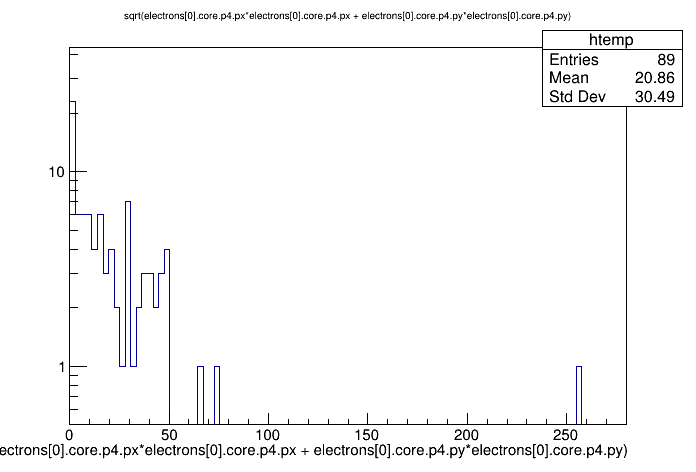

In [11]:
import ROOT
c = ROOT.TCanvas()
f = ROOT.TFile("pp_h_4l.root")
# get event tree
events = f.Get("events")
events.Draw("sqrt(electrons[0].core.p4.px*electrons[0].core.p4.px + electrons[0].core.p4.py*electrons[0].core.p4.py)")
ROOT.gPad.SetLogy()
c.Draw()


To save time and computing power, more events with the same configuration can be taken from eos:

In [12]:
!export EOS_MGM_URL="root://eospublic.cern.ch"
!cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_h_4l.root .
!cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_zgzg_4l.root .



Part II: Analyze the output with Heppy
------------------------------------------


[Heppy](https://github.com/HEP-FCC/heppy) is a python framework suitable for analyzing the FCCSW output.


Understand the configuration file for this **H->4l analysis**: [`analysis_pp_hTo4l_simple_cfg.py`](https://github.com/HEP-FCC/heppy/blob/master/heppy/test/analysis_pp_hTo4l_simple_cfg.py)
This is where **filters** on input collections and **event selection** are defined.
The sequence is divided in two parts, a gen level analysis, and a reco level.

-   The **gen level analysis** simply filters interesting leptons (`gen_leptons`) and stores pT, eta in in flat tree (`gen_tree`).

Have a look at the corresponding code in `heppy/analyzers/examples/hzz4l/HTo4lGenTreeProducer.py`.

-   The **reco level analysis** first **selects isolated leptons** (`selected_muons`, `selected_electrons`), merges them into a single collection (`selected_leptons`),
**builds Z candidates** (`zeds`) and finally **builds higgs candidates**  (`higgses`). After that an **event selection** is applied (`selection`).

Open `heppy/analyzers/examples/hzz4l/selection.py` and understand the event selection.

Finally another flat tree is produced `HTo4lTreeProducer`.
This tree contains contains all relevant information for the two reconstructed Z bosons, the Higgs, and the four associated leptons.
For comparison, also the MC level counterparts of the reconstructed quantities are stored.

To summarize, when designing a new analysis, you will have to define:

- a configuration file containing the analysis sequence
- an event selection
- one or several tree producer(s) where the variables to be stored in the output tree(s) are specified
- optionally, new modules that are specific to your analysis (e.g. `LeptonicZedBuilder` here)

Now run HEPPY:

In [22]:
!heppy_loop.py pp_h_4l analysis_pp_hTo4l_simple_cfg.py -f -N 1000 -I root://eospublic.cern.ch//eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_h_4l.root;

TClass::Init:0: RuntimeWarning: no dictionary for class fcc::FloatData is available
event 100 (57.2 ev/s)
event 200 (73.2 ev/s)
event 300 (87.4 ev/s)
event 400 (100.6 ev/s)
event 500 (111.0 ev/s)
event 600 (118.6 ev/s)
event 700 (125.5 ev/s)
event 800 (131.2 ev/s)
event 900 (135.3 ev/s)

Component: example
	dataset_entries:   0
	files          :   ['root://eospublic.cern.ch//eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_h_4l.root']
	isData         :   False
	isEmbed        :   False
	isMC           :   False
	tree_name      :   None
	triggers       :   None


      ---- TimeReport (all times in ms; first evt is skipped) ---- 
processed    all evts    time/proc    time/all   [%]    analyer
---------    --------    ---------   ---------  -----   -------------
     1000        1000         5.75        5.75  82.3%   heppy.analyzers.fcc.Reader.Reader_1
     1000        1000         0.06        0.06   0.9%   heppy.analyzers.Selector.Selector_gen_leptons
     1000        1000         0.51      

In [18]:
!heppy_loop.py pp_zgzg_4l analysis_pp_hTo4l_simple_cfg.py -f -N 1000 -I root://eospublic.cern.ch//eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_zgzg_4l.root;

TClass::Init:0: RuntimeWarning: no dictionary for class fcc::FloatData is available
event 100 (71.2 ev/s)
event 200 (78.6 ev/s)
event 300 (97.0 ev/s)
event 400 (112.2 ev/s)
event 500 (120.7 ev/s)
event 600 (126.6 ev/s)
event 700 (134.1 ev/s)
event 800 (140.4 ev/s)
event 900 (145.6 ev/s)

Component: example
	dataset_entries:   0
	files          :   ['root://eospublic.cern.ch//eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_zgzg_4l.root']
	isData         :   False
	isEmbed        :   False
	isMC           :   False
	tree_name      :   None
	triggers       :   None


      ---- TimeReport (all times in ms; first evt is skipped) ---- 
processed    all evts    time/proc    time/all   [%]    analyer
---------    --------    ---------   ---------  -----   -------------
     1000        1000         5.48        5.48  84.2%   heppy.analyzers.fcc.Reader.Reader_1
     1000        1000         0.06        0.06   1.0%   heppy.analyzers.Selector.Selector_gen_leptons
     1000        1000         0.49   

The runs create two output directories `pp_h_4l` and `pp_zgzg_4l`, with various subdirectories. The breakdown of
efficiencies by cut can be found in:

`example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt`

In [23]:
!cat pp_h_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt

Counter cut_flow :
	 All events                                                        1000 	 1.00 	 1.0000
	 At least one Z -> l+ l- candidates                                 985 	 0.98 	 0.9850
	 40 < mZ1 < 120                                                     811 	 0.82 	 0.8110
	 At least a second Z -> l+ l- candidates                            449 	 0.55 	 0.4490
	 12 < mZ2 < 120                                                     441 	 0.98 	 0.4410
	 leading lepton pT > 20                                             437 	 0.99 	 0.4370
	 sub-leading lepton pT > 10                                         436 	 1.00 	 0.4360



In [24]:
!cat pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt

Counter cut_flow :
	 All events                                                        1000 	 1.00 	 1.0000
	 At least one Z -> l+ l- candidates                                 958 	 0.96 	 0.9580
	 40 < mZ1 < 120                                                     689 	 0.72 	 0.6890
	 At least a second Z -> l+ l- candidates                            362 	 0.53 	 0.3620
	 12 < mZ2 < 120                                                     278 	 0.77 	 0.2780
	 leading lepton pT > 20                                             274 	 0.99 	 0.2740
	 sub-leading lepton pT > 10                                         273 	 1.00 	 0.2730



The **gen-level** and **reco-level** output trees can be found here:

`example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root`
`example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root`

## Part III: Produce plots


Produce Gen-level plots:

In [25]:

import ROOT
from ROOT import TFile, gROOT, TH1D, kRed, TLegend
import os


def printCanvas(canvas, name, format, directory):
    if format != "":
        if not os.path.exists(directory) :
                os.system("mkdir "+directory)
        outFile = os.path.join(directory, name) + "." + format
        canvas.Print(outFile)



def drawDoublehisto(h1, h2, name, ylabel, legend, leftText, rightText, format, directory, logY):
    if logY : 
        name = name+"_logY"
    canvas = ROOT.TCanvas(name, name, 700, 600) 
    if logY : 
        canvas.SetLogy(1)
    
    font = 132
    
    ROOT.gPad.SetLeftMargin(0.20) ; 
    ROOT.gPad.SetRightMargin(0.10) ; 
    ROOT.gPad.SetBottomMargin(0.20) ; 
    ROOT.gStyle.SetOptStat(0000000);
    ROOT.gStyle.SetTextFont(font);
    
    Tleft = ROOT.TLatex(0.20, 0.92, leftText) 
    Tleft.SetNDC(ROOT.kTRUE) 
    Tleft.SetTextSize(0.044) 
    Tleft.SetTextFont(font) 
    
    Tright = ROOT.TText(0.90, 0.92, rightText) ;
    Tright.SetTextAlign(31);
    Tright.SetNDC(ROOT.kTRUE) 
    Tright.SetTextSize(0.044) 
    Tright.SetTextFont(font) 
    
    maxh = max(h1.GetMaximum(),h2.GetMaximum())
    
    h1.GetXaxis().SetTitleFont(font)
    h1.GetXaxis().SetLabelFont(font)
    
    h1.GetYaxis().SetTitle(ylabel)
    h1.GetYaxis().SetTitleFont(font)
    h1.GetYaxis().SetLabelFont(font)
    h1.GetXaxis().SetTitleOffset(1.5)
    h1.GetYaxis().SetTitleOffset(1.6)
    h1.GetXaxis().SetLabelOffset(0.02)
    h1.GetYaxis().SetLabelOffset(0.02)
    h1.GetXaxis().SetTitleSize(0.06)
    h1.GetYaxis().SetTitleSize(0.06)
    h1.GetXaxis().SetLabelSize(0.06)
    h1.GetYaxis().SetLabelSize(0.06)
    h1.SetNdivisions(505);
    h1.GetYaxis().SetNdivisions(505);

    h1.SetMaximum(1.5*maxh) 
    h1.SetTitle("") 
    h1.Draw("")
    h2.Draw("same")

    legend.SetTextFont(font) 
    legend.Draw() 
    Tleft.Draw() 
    Tright.Draw() 
    printCanvas(canvas, name, format, directory) 
    canvas.Draw()


treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"

Vars = {   
    "lep1vsPt_pt":{"name":"lep1vsPt_pt","title":"p_{T}^{(1)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep2vsPt_pt":{"name":"lep2vsPt_pt","title":"p_{T}^{(2)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep3vsPt_pt":{"name":"lep3vsPt_pt","title":"p_{T}^{(3)} [GeV]","bin":25,"xmin":0,"xmax":50},
    "lep4vsPt_pt":{"name":"lep4vsPt_pt","title":"p_{T}^{(4)} [GeV]","bin":25,"xmin":0,"xmax":50},

    "lep1vsEta_eta":{"name":"lep1vsEta_eta","title":"#eta^{(1)}","bin":25,"xmin":0,"xmax":10},
    "lep2vsEta_eta":{"name":"lep2vsEta_eta","title":"#eta^{(2)}","bin":25,"xmin":0,"xmax":10},
    "lep3vsEta_eta":{"name":"lep3vsEta_eta","title":"#eta^{(3)}","bin":25,"xmin":0,"xmax":10},
    "lep4vsEta_eta":{"name":"lep4vsEta_eta","title":"#eta^{(4)}","bin":25,"xmin":0,"xmax":10}
}


rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)

dict_histoS =  {}
dict_histoB = {}
for var in Vars:
    dict_histoS[var] = TH1D(var+"S", var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"])
    dict_histoB[var] = TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"])



for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))


yAxisLabel = "a. u."

rightText = "GEN"
leftText = "#sqrt{s} = 100 TeV"
format = "png"
outputDirectory = "plots" 

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
    dict_histoS[var].SetLineWidth(3)
    dict_histoS[var].SetLineWidth(3)
    dict_histoB[var].SetLineColor(ROOT.kRed)
   
    try : 
        dict_histoS[var].Scale(1./float(dict_histoS[var].Integral()))
        dict_histoB[var].Scale(1./float(dict_histoB[var].Integral()))
    except ZeroDivisionError :
        print("Can not renormalize because of integral = 0.") 
    
    leg = TLegend(0.50,0.76,0.89,0.89)
    leg.AddEntry(dict_histoS[var],"p p #rightarrow H #rightarrow 4l","l")
    leg.AddEntry(dict_histoB[var],"p p #rightarrow ZZ / Z #gamma^{*} #rightarrow 4l","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)
    #c = ROOT.TCanvas()
    drawDoublehisto(dict_histoS[var],dict_histoB[var],var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0)
    #c.Draw()




Info in <TCanvas::Print>: png file plots/lep3vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep4vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep3vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep2vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep1vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep4vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep2vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep1vsPt_pt.png has been created



The plots can be found in the `plots` directory:

![](plots/lep4vsPt_pt.png)

<img src="./images/FccFullAnalysis/lep1vsPt_pt.png" width="400">
<img src="./images/FccFullAnalysis/lep1vsEta_eta.png" width="400">

Produce Reco-level plots:

Appreciate the signal yield for **25 fb-1 of data**. Compare with [ATLAS results](https://arxiv.org/pdf/1408.5191v3.pdf) at 7,8 TeV .

<img src="./images/FccFullAnalysis/higgs_m.png" width="30%">
<img src="./images/FccFullAnalysis/m4l_80_170_allYear_125.png" width="30%">

In [26]:
# %load tutorials/fcc/createRecoHistos.py
from ROOT import TFile, gROOT, TH1D, kRed, TLegend, THStack
#from tools.drawCanvas import *
import os

def printCanvas(canvas, name, format, directory):
    if format != "":
        if not os.path.exists(directory) :
                os.system("mkdir "+directory)
        outFile = os.path.join(directory, name) + "." + format
        canvas.Print(outFile)

        
def drawStack(name, ylabel, legend, leftText, rightText, format, directory, logY, hS, hB):
    if logY : 
        name = name+"_logY"
    canvas = ROOT.TCanvas(name, name, 700, 600) 
    if logY : 
        canvas.SetLogy(1)
    
    font = 132
    
    ROOT.gPad.SetLeftMargin(0.20) ; 
    ROOT.gPad.SetRightMargin(0.10) ; 
    ROOT.gPad.SetBottomMargin(0.20) ; 
    ROOT.gStyle.SetOptStat(0000000);
    ROOT.gStyle.SetTextFont(font);
    
    Tleft = ROOT.TLatex(0.20, 0.92, leftText) 
    Tleft.SetNDC(ROOT.kTRUE) 
    Tleft.SetTextSize(0.044) 
    Tleft.SetTextFont(font) 
    
    Tright = ROOT.TText(0.90, 0.92, rightText) ;
    Tright.SetTextAlign(31);
    Tright.SetNDC(ROOT.kTRUE) 
    Tright.SetTextSize(0.044) 
    Tright.SetTextFont(font) 
    
    # first retrieve maximum 
    maxes = []
    maxes.append(hS.GetMaximum())
    for h in hB:
       maxes.append(h.GetMaximum())
    
    maxh = max(maxes)
     
    # define stacked histo
    hStack = ROOT.THStack("hstack","")
    colors = []
    colors.append(ROOT.kCyan-6);
    colors.append(ROOT.kBlue-6);
    colors.append(ROOT.kGreen-6);
    colors.append(ROOT.kMagenta-6);
    colors.append(ROOT.kOrange-6);
   
    # first plot backgrounds
         
    hB[0].SetLineWidth(2)
    hB[0].SetLineColor(ROOT.kBlack)
    hB[0].SetFillColor(colors[0])
    
    hStack.Add(hB[0])
    
    # now loop over other background (skipping first)
    iterh = iter(hB)
    next(iterh)
    
    for h in iterh:
       h.SetLineWidth(2)
       h.SetLineColor(ROOT.kBlack)
       h.SetFillColor(colors[k])
       hStack.Add(h)
    
    
    # finally add signal on top
    hS.SetLineWidth(2)
    hS.SetLineColor(ROOT.kRed+1)
    hStack.Add(hS)
    
    hStack.Draw("hist")
   
    hStack.GetXaxis().SetTitleFont(font)
    hStack.GetXaxis().SetLabelFont(font)
    hStack.GetXaxis().SetTitle(hB[0].GetXaxis().GetTitle())
    hStack.GetYaxis().SetTitle(ylabel)
    hStack.GetYaxis().SetTitleFont(font)
    hStack.GetYaxis().SetLabelFont(font)
    hStack.GetXaxis().SetTitleOffset(1.5)
    hStack.GetYaxis().SetTitleOffset(1.6)
    hStack.GetXaxis().SetLabelOffset(0.02)
    hStack.GetYaxis().SetLabelOffset(0.02)
    hStack.GetXaxis().SetTitleSize(0.06)
    hStack.GetYaxis().SetTitleSize(0.06)
    hStack.GetXaxis().SetLabelSize(0.06)
    hStack.GetYaxis().SetLabelSize(0.06)
    hStack.GetXaxis().SetNdivisions(505);
    hStack.GetYaxis().SetNdivisions(505);
    hStack.SetMaximum(1.5*maxh) 
    hStack.SetTitle("") 
    
   
    legend.SetTextFont(font) 
    legend.Draw() 
    Tleft.Draw() 
    Tright.Draw() 
    printCanvas(canvas, name, format, directory) 

treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"

# number of generated events
nGenS = 10000
nGenB = 10000

# integrated luminosity
intLumi = 25000

kFactorS = 3.50
kFactorB = 1.80

# MG5 LO XS x BR in (pb)
sigmaS = 0.026
sigmaB = 1.04

weightS = kFactorS*sigmaS*intLumi/nGenS
weightB = kFactorB*sigmaB*intLumi/nGenB

Vars = {   
    "zed1_m":{"name":"zed1_m","title":"m_{ll}^{(1)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "zed2_m":{"name":"zed2_m","title":"m_{ll}^{(2)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "higgs_m":{"name":"higgs_m","title":"m_{4l} [GeV]","bin":36,"xmin":70,"xmax":170},
}

rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)

dict_histoS = {var:TH1D(var+"S",var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}
dict_histoB = {var:TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}




for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)

    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))

#myBTGStyle()

yAxisLabel = "Events / 2.5 GeV"

rightText = "RECO: Delphes-3.4.0"
leftText = "#sqrt{s} = 100 TeV, L = 25 fb^{-1}"
format = "png"
outputDirectory = "plots" 
outFile = outputDirectory+"/plots.root"

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
     
    try : 
        
	# rescale by
        dict_histoS[var].Scale(weightS)
        dict_histoB[var].Scale(weightB)

    except ZeroDivisionError :
        print "Can not renormalize because of integral = 0." 
    
    leg = TLegend(0.69,0.75,0.88,0.88)
    leg.AddEntry(dict_histoB[var],"ZZ / Z #gamma^{*}","f")
    leg.AddEntry(dict_histoS[var],"H(125)","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)

    hS = dict_histoS[var]
    hB = []
    hB.append(dict_histoB[var])

    drawStack(var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0,hS,hB)







Info in <TCanvas::Print>: png file plots/higgs_m.png has been created
Info in <TCanvas::Print>: png file plots/zed2_m.png has been created
Info in <TCanvas::Print>: png file plots/zed1_m.png has been created


![](plots/higgs_m.png)
![](plots/zed2_m.png)
![](plots/zed1_m.png)

Part IV: Homework
---------------------

As an exercise you can **re-run the full analysis with the CMS detector configuration**. 
Additional Delphes cards canbe found in the `$DELPHES_DIR/cards` folder of your Delphes installation. 

Hint: The input Delphes card can be specified in the command line argument: 
```
--DelphesCard /cvmfs/sft.cern.ch/lcg/releases/LCG_94/delphes/3.4.2pre12/x86_64-centos7-gcc62-opt/cards/delphes_card_CMS.tcl
```

You should obtain a plot similar to the following!


![You should obtain a plot similar to this one.](images/FccFullAnalysis/higgs_m_cms.png)

By comparing the CMS and FCC Delphes cards, try to explain:

-  the **event yields difference between 7/8 TeV and 100 TeV** (by comparing the official ATLAS plot with the CMS configuration you just ran at 100 TeV)
-  the **event yields difference at 100 TeV** between the CMS and FCC detector configurations
-  the **difference in the width of Z and H peaks** between the CMS and FCC detector configurations

[]() Other documentation
------------------------

-   [Submit FCCSW jobs using the condor queue](https://github.com/HEP-FCC/fcc-tutorials/blob/master/FccCondor.md)
-   [Submit Heppy jobs using the batch queue](https://github.com/HEP-FCC/heppy/blob/master/doc/Heppy_-_Parallel_Processing.md)
-   [FCCSW webpage](http://fccsw.web.cern.ch/fccsw/index.html)
-   [Pythia8 manual](http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html)
-   [Delphes website](https://cp3.irmp.ucl.ac.be/projects/delphes)

------------------------------------------------------------------------





























